# En XGB modell för att estimera priset på en diamant

## 0. Importer
Först kommer alla importer som behövs för projektet

In [81]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split

## 1. Förberedning av data
Vi börjar med att ladda in datasetet

In [63]:
df = pd.read_csv('diamonds.csv')

original_length = df.shape[0]

# Dubeltter och en kolumn med index
df.drop_duplicates(inplace=True)
df.drop('Unnamed: 0', axis='columns', inplace=True)

display(df.head())

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 1.1 Visualisering
Vi skapar några grafer för att visualisera datan

Här skapas en funktion som jämför varje kolumn med den diamantens pris. Vi kan hoppa över *cut*, *color* och *clarity* eftersom det är kategoriska

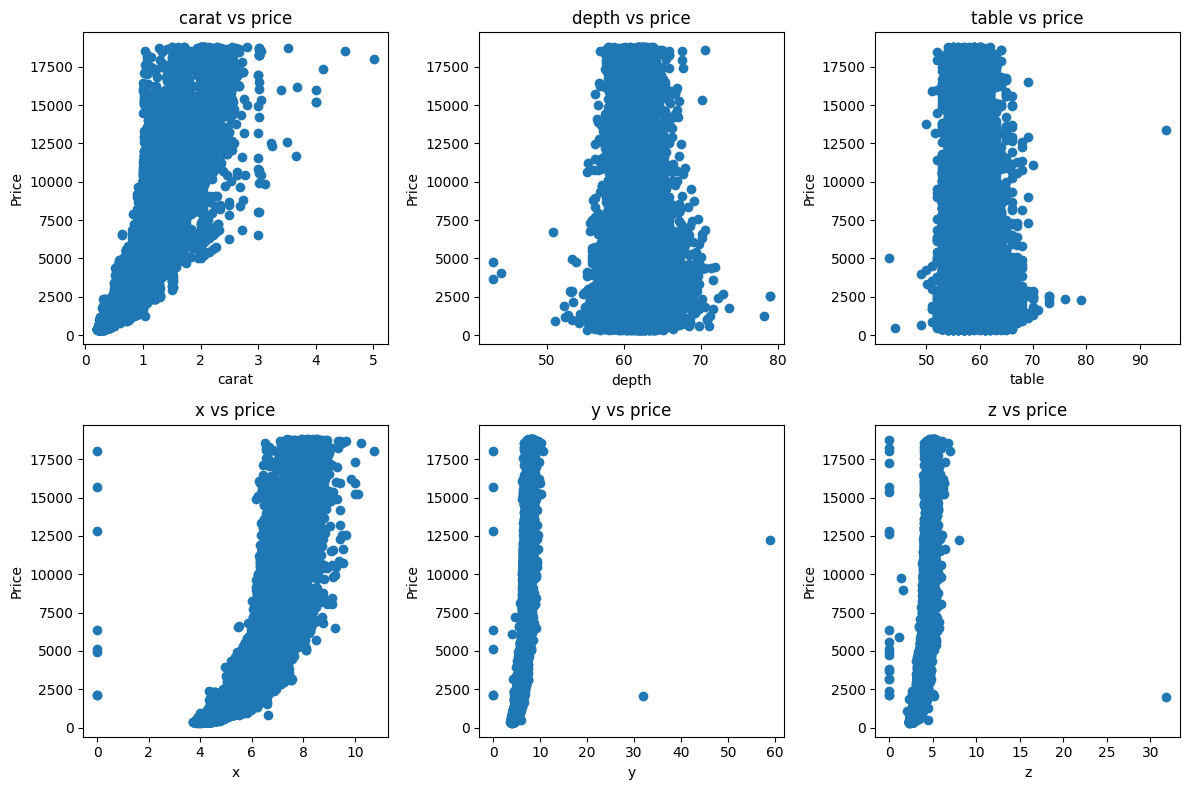

In [64]:
def plot_statistics():
    '''Rita en jämförelse mellan pris och alla andra kolumner'''

    plt.figure(figsize=(12, 8))
    for n, column in enumerate(df.drop(columns=['price', 'cut', 'color', 'clarity']).columns, 1):
        plt.subplot(2, 3, n)
        plt.scatter(df[column], df['price'])
        plt.xlabel(column)
        plt.ylabel('Price')
        plt.title(f'{column} vs price')

    plt.tight_layout()

plot_statistics()

## 1.2 Förbehandling

Vi ser att det på flera platser finns punkter som sticker ut mycket från resten av datan, och därför vill vi sortera bort dem.

Från grafen ser vi att några av diamanternas *y* eller *z* är noll. Det finns också några som har väldigt stora värden. En diamant som saknar en dimension, eller har en orimlig storlek är inte så bra att ta med i träningsdatan, så vi tar bort dem.

In [65]:
df.drop(df[df['y'] == 0].index, inplace=True)
df.drop(df[df['y'] > 20].index, inplace=True)

df.drop(df[df['z'] < 2].index, inplace=True)
df.drop(df[df['z'] > 6.5].index, inplace=True)

Även i kolumnerna *depth* och *table* så finns det värden som sticker ut mycket

In [66]:
df.drop(df[df['depth'] < 47.5].index, inplace=True)
df.drop(df[df['depth'] > 77.5].index, inplace=True)

df.drop(df[df['table'] < 45].index, inplace=True)
df.drop(df[df['table'] > 75].index, inplace=True)

Hur ser det ut efter allt detta?

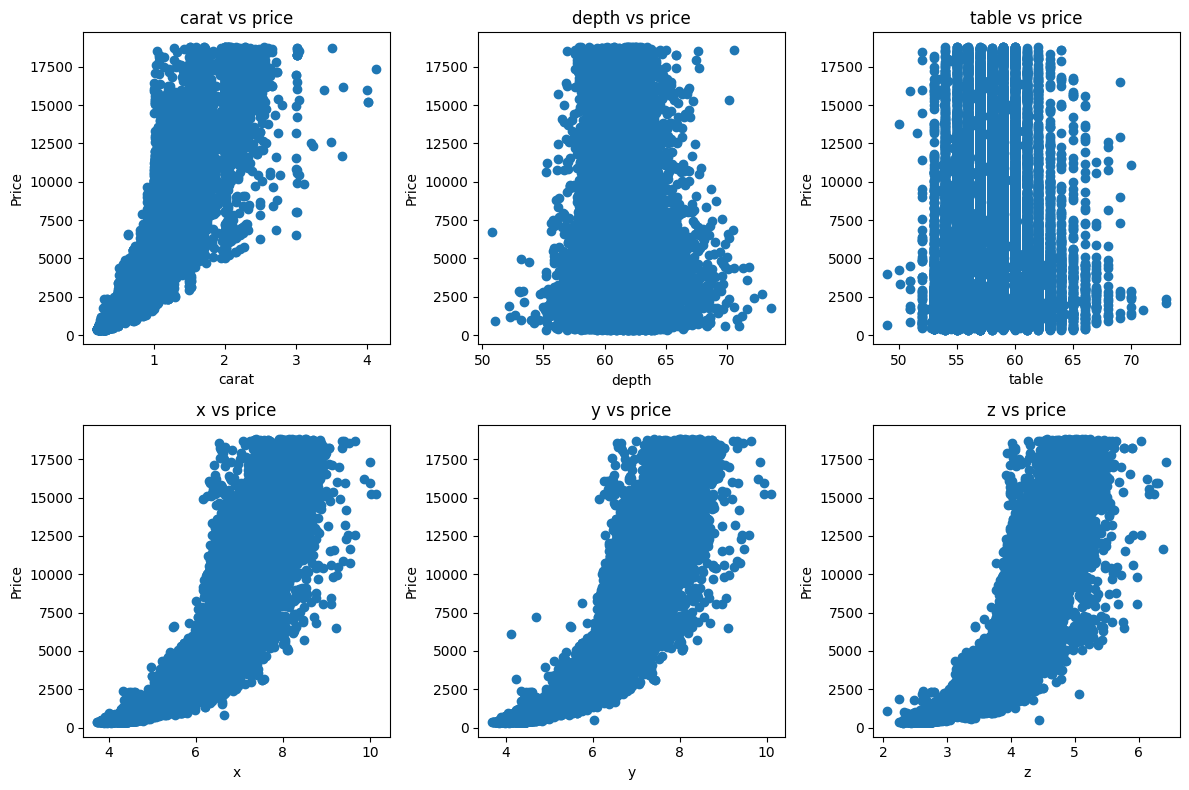

In [67]:
plot_statistics()

Under hela processen har vi bara förlorat 39 diamanter

In [68]:
print(f'{original_length - df.shape[0]} eller {round((original_length - df.shape[0]) / original_length, 4)}% av datapunkter borttagna')

39 eller 0.0007% av datapunkter borttagna


Det finns fortfarande några kolumner som har kategoriska värden (*cut*, *color*, *clarity*). Detta går inte att mata till modellen, så jag använder get_dummies för att konvertera till individuella kolumner liknande till en OneHotEncoder. Sedan tas kolumnerna med kategoriska värden bort

In [69]:
encoded_cut = pd.get_dummies(df['cut'], 'cut:', ' ')
encoded_color = pd.get_dummies(df['color'], 'color:', ' ')
encoded_clarity = pd.get_dummies(df['clarity'], 'clarity:', ' ')
df.drop(columns=['cut', 'color', 'clarity'], inplace=True)

df = pd.concat([encoded_cut, encoded_color, encoded_clarity, df], axis=1)

display(df.head())

,cut: Fair,cut: Good,cut: Ideal,cut: Premium,cut: Very Good,color: D,color: E,color: F,color: G,color: H,...,clarity: VS2,clarity: VVS1,clarity: VVS2,carat,depth,table,price,x,y,z
0,False,False,True,False,False,False,True,False,False,False,...,False,False,False,0.23,61.5,55.0,326,3.95,3.98,2.43
1,False,False,False,True,False,False,True,False,False,False,...,False,False,False,0.21,59.8,61.0,326,3.89,3.84,2.31
2,False,True,False,False,False,False,True,False,False,False,...,False,False,False,0.23,56.9,65.0,327,4.05,4.07,2.31
3,False,False,False,True,False,False,False,False,False,False,...,True,False,False,0.29,62.4,58.0,334,4.20,4.23,2.63
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,0.31,63.3,58.0,335,4.34,4.35,2.75


## 2. Skapa en modell
Först delas datan upp för träning och testning. Standardvärdet för delningen är 0.25, alltså blir 75% träning och 25% testning.

In [70]:
X = df.drop(columns='price')
y_pred = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y_pred, random_state=0)

Vi skapar den mest grundläggande versionen som går och testar hur bra den fungerar

In [71]:
model: xgb.Booster = xgb.XGBRegressor(random_state=0)
model.fit(X_train, y_train);

Nu kan vi göra lite visualisering om hur bra den är. På graferna kan vi också rita en linje som visar vart punkterna ska vara. I första är det där modellens och det faktiska värdena är samma, och på den andra så är linjen där skillnaden mellan faktiska och modellens är noll.

Mean Absolute Error (MAE):      281
Mean Squared Error (MSE):       308463
Root Mean Squared Error (RMSE): 555


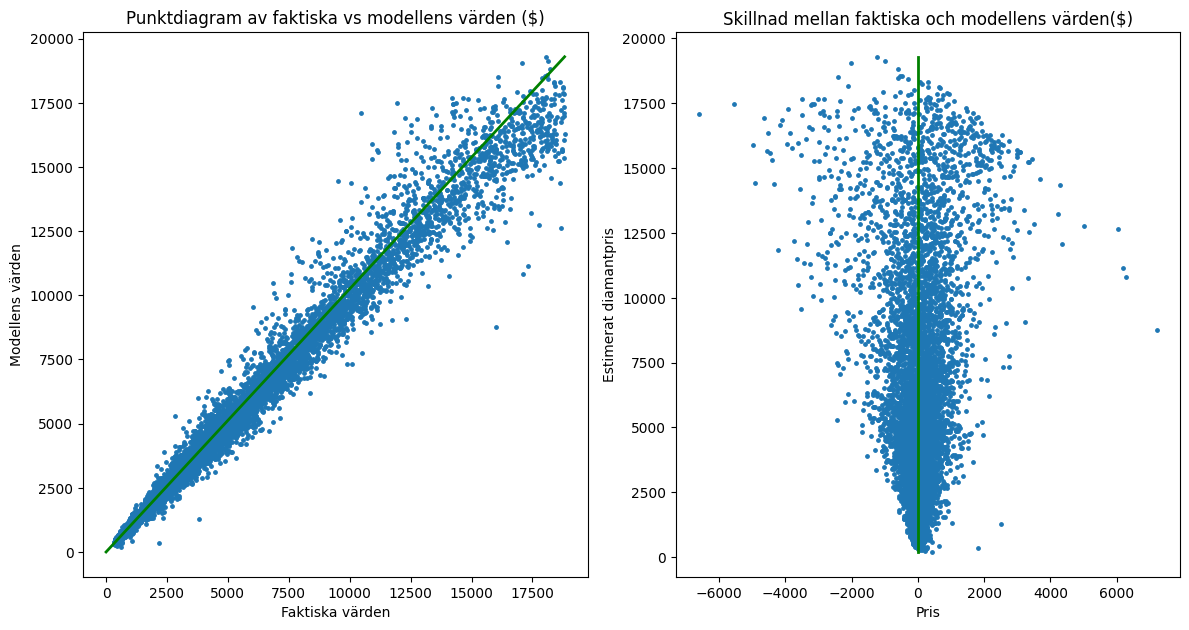

In [72]:
def plot_perf(model):
    '''Skapa en grafer som visar modellens prestanda'''

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (MAE):      {mae:.0f}')
    print(f'Mean Squared Error (MSE):       {mse:.0f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.0f}')

    # Punktdiagram (faktiskt vs modell)
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, s=6)
    plt.plot([0, max(y_test)], [0, max(y_pred)], 'g', linewidth=2)
    plt.xlabel('Faktiska värden')
    plt.ylabel('Modellens värden')
    plt.title('Punktdiagram av faktiska vs modellens värden ($)')

    # Punktdiagram (fel)
    difference = y_test - y_pred
    plt.subplot(2, 2, 2)
    plt.scatter(difference, y_pred, s=6)
    plt.plot([0, 0], [min(y_pred), max(y_pred)], 'g', linewidth=2)
    plt.xlabel('Pris')
    plt.ylabel('Estimerat diamantpris')
    plt.title('Skillnad mellan faktiska och modellens värden($)')

    plt.tight_layout()

plot_perf(model)

Det var ändå ganska bra, modellen är genomsnittligt $283 fel.

# 3. Justera och förbättra
En sådan här modell kan ta väldigt många parametrar som alla påverkar dess precision. Det finns verktyg som är gjorda för att testa flera kombinationer för att hitta den bästa möjliga. Det två stora är gridsearch och randomizedSearch. Grid testar all möjliga kombinationer, medans random testar slumpmässigt valdra hyperparametrar ett bestämt antal gånger. Grid är garanterat att hitta den bästa modellen, men random kan hitta något fortfarande mycket bra, på färre försök. Jag väljer att använda randomizedSearch. Först skapar vi ett randomsearch objekt med alla möjliga värden som ska användas.

In [73]:
param_dist = {
    'learning_rate': [0.5, 0.1, 0.05, 0.01, 0.005, 0.001],  # Hur snabbt värden förändras vid varje iteration
    'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600], # Antal steg att träna modellen

    'max_depth': [2, 3, 4, 5, 6, 7, 8],                     # Maximalt djup för varje träd
    'min_child_weight': [1, 2, 3, 4, 5],                    # Hur mycket som krävs för att trädet ska dela sig
    'gamma': [0, 1, 2, 3, 4, 5],                            # Minimum kravet på förbättring för att trädet ska dela sig

    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],       # Andel av kolumnerna som tas med vid varje delning i trädet (förändringsfaktor)
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],         # Andel av träningsdatan som tas med vid träningen av varje träd (förändringsfaktor)

    'eval_metric': ['rmse'],                                # Hur modellen ska utväderas
    'random_state': [0]                                     # För reproducerbarhet
}

rs = RandomizedSearchCV(
    xgb.XGBRegressor(),
    param_dist,
    n_iter=100
)

rs.fit(X_train, y_train);

Med randomizedSearch har vi nu testat 100 kombinationer av värden. GridSearch hade gjort 423 360. Nu ska vi se hur bra den här modellen är.

Mean Absolute Error (MAE):      269
Mean Squared Error (MSE):       295778
Root Mean Squared Error (RMSE): 544


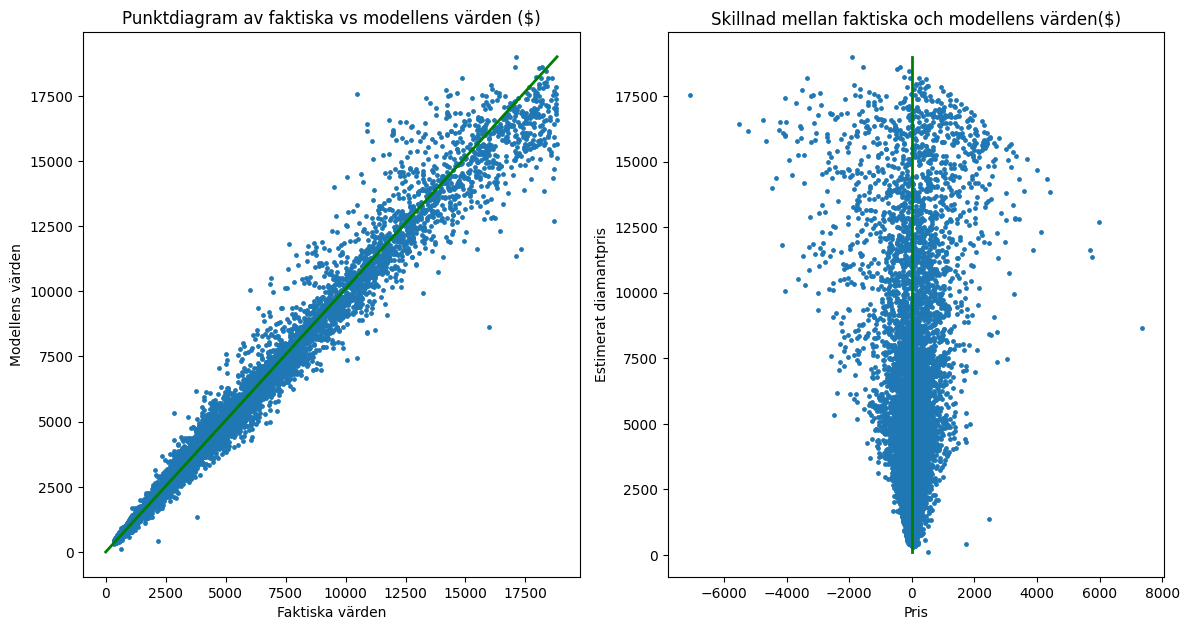

In [96]:
plot_perf(rs.best_estimator_)

In [116]:
def save_best_model(rs: RandomizedSearchCV) -> None:
    '''Spara modellen om den är bättre än tidigare sparad modell'''

    saved_score = 0

    for file in os.listdir():
        if file.endswith('.ubj'):
            saved_score = float(file.rsplit('.', maxsplit=1)[0])

    if rs.best_score_ > saved_score:
        rs.best_estimator_.save_model(f'{rs.best_score_}.ubj')
        print('Modellen är bättre och har sparats')

save_best_model(rs)

Modellen är bättre och har sparats
